<>:106: SyntaxWarning: invalid escape sequence '\D'
<>:106: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_10594/3483105004.py:106: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('Waiting Time $\Delta t$ (Log Scale)', fontsize=12)


=== 孪生素数间歇性分析 (Critical Intermittency) ===
生成真实孪生素数数据...
生成混沌孪生事件...
计算分布并绘图...


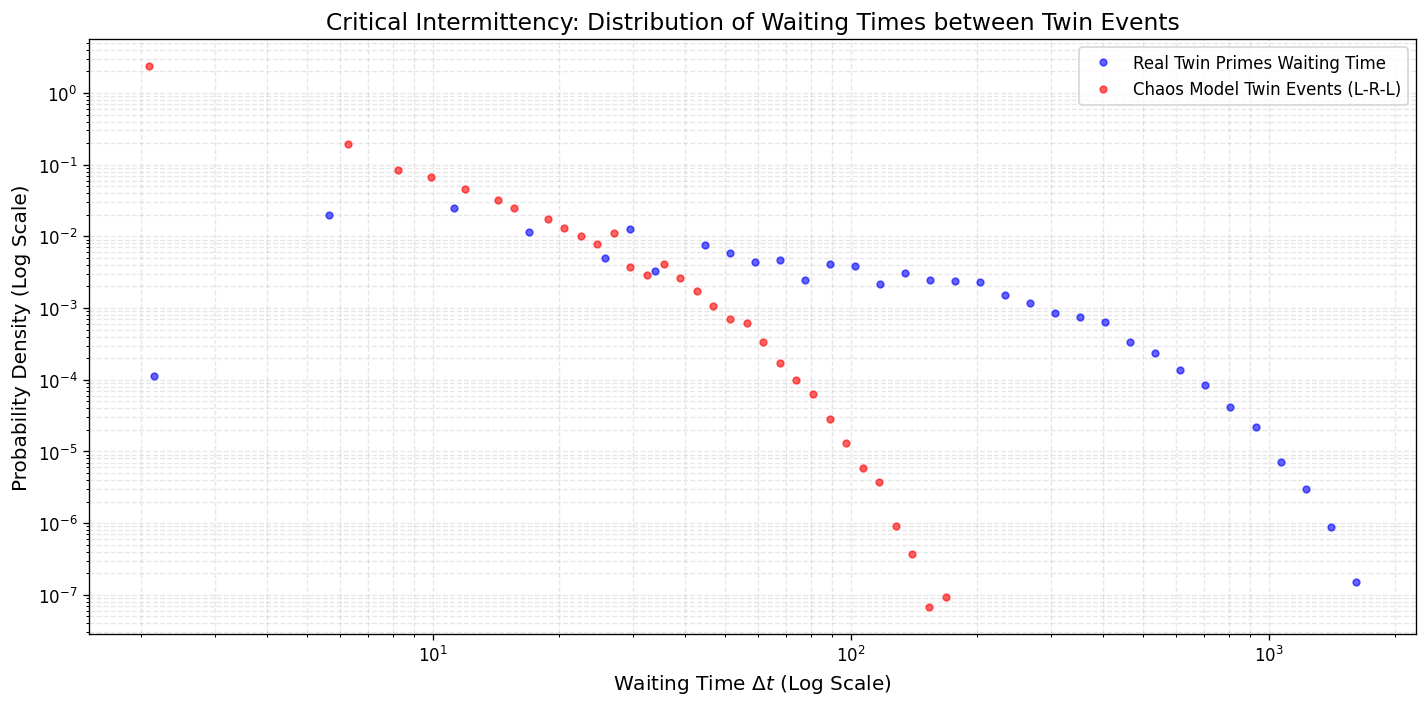

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_twin_intermittency(limit=10_000_000):
    print("=== 孪生素数间歇性分析 (Critical Intermittency) ===")
    
    # ============================
    # 1. 真实孪生素数等待时间
    # ============================
    print("生成真实孪生素数数据...")
    # 快速筛法
    sieve = np.ones(limit // 2, dtype=bool)
    for i in range(3, int(limit**0.5) + 1, 2):
        if sieve[i // 2]:
            sieve[i*i // 2 :: i] = False
    primes = np.array([1] + [2 * i + 1 for i in range(1, limit // 2) if sieve[i]])
    
    # 找到孪生素数对的位置 (p, p+2 都是素数)
    # diff(primes) == 2 的位置
    prime_diffs = np.diff(primes)
    twin_indices = np.where(prime_diffs == 2)[0]
    twin_primes = primes[twin_indices]
    
    # 计算由于"间歇性"导致的等待时间 (两个孪生对之间的距离)
    # T_n = Twin_{n+1} - Twin_n
    twin_waiting_times = np.diff(twin_primes)
    
    # ============================
    # 2. 混沌模型孪生事件
    # ============================
    print("生成混沌孪生事件...")
    u = 1.543689012692076
    
    # 我们需要足够多的事件，因为孪生事件是二阶小概率
    # 运行步数设大一点
    sim_steps = limit * 2 
    
    # 使用 Boolean 数组快速运算
    # 1. 生成轨迹
    x = 0.1
    # 预生成随机数用于老化筛选 (模拟 1/ln n 密度衰减)
    # 为了简化且聚焦于"动力学间歇性"，我们先看纯混沌结构(Static)，
    # 再叠加老化(Aging)太慢，且间歇性主要由动力学决定。
    # 这里我们采用"静态混沌"来捕捉L-R-L结构的核心分布。
    
    traj = np.zeros(sim_steps)
    x_curr = x
    for i in range(10000): x_curr = 1 - u * x_curr**2 # 预热
    
    for i in range(sim_steps):
        x_curr = 1 - u * x_curr**2
        traj[i] = x_curr
        
    # 2. 识别 L (x < 0)
    is_L = traj < 0
    
    # 3. 识别孪生模式: L (t) AND L (t+2)
    # shift -2
    # event[i] is True if traj[i] < 0 AND traj[i+2] < 0
    # 注意数组边界
    is_twin_chaos = is_L[:-2] & is_L[2:]
    
    # 获取发生时刻
    chaos_twin_times = np.nonzero(is_twin_chaos)[0]
    chaos_waiting_times = np.diff(chaos_twin_times)
    
    # ============================
    # 3. 统计与绘图 (Log-Log PDF)
    # ============================
    print("计算分布并绘图...")
    
    plt.figure(figsize=(12, 6), dpi=120)
    
    # 辅助函数：计算对数分箱的 PDF
    def get_log_pdf(data, bins=50):
        # 过滤掉过大的异常值以便绘图
        data = data[data > 0]
        if len(data) == 0: return [], []
        
        # 对数分箱
        min_val = np.min(data)
        max_val = np.max(data)
        log_bins = np.logspace(np.log10(min_val), np.log10(max_val), bins)
        
        hist, edges = np.histogram(data, bins=log_bins, density=True)
        centers = (edges[:-1] + edges[1:]) / 2
        
        # 过滤掉 0 值
        valid = hist > 0
        return centers[valid], hist[valid]

    # 计算真实孪生素数的分布
    x_real, y_real = get_log_pdf(twin_waiting_times)
    # 计算混沌模型的分布
    x_chaos, y_chaos = get_log_pdf(chaos_waiting_times)
    
    # 绘图
    plt.loglog(x_real, y_real, 'b.', markersize=8, alpha=0.6, label='Real Twin Primes Waiting Time')
    plt.loglog(x_chaos, y_chaos, 'r.', markersize=8, alpha=0.6, label='Chaos Model Twin Events (L-R-L)')
    
    # 绘制参考线：幂律衰减 (Power Law) vs 指数衰减 (Poisson)
    # 间歇性通常表现为幂律: P(t) ~ t^(-mu)
    # 泊松分布表现为指数: P(t) ~ e^(-kt) (在双对数图上是弯曲的)
    
    plt.title('Critical Intermittency: Distribution of Waiting Times between Twin Events', fontsize=14)
    plt.xlabel('Waiting Time $\Delta t$ (Log Scale)', fontsize=12)
    plt.ylabel('Probability Density (Log Scale)', fontsize=12)
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.3)
    
    plt.tight_layout()
    plt.show()

analyze_twin_intermittency()